In [1]:
pip install pandas scikit-learn matplotlib seaborn


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive



🔍 Model Evaluation:
Accuracy: 0.15890461997019373

Classification Report:
                                      precision    recall  f1-score   support

    Bajaj Allianz Life Smart Protect       0.04      0.05      0.04       152
                HDFC Click 2 Protect       0.12      0.07      0.09       205
     ICICI Prudential iProtect Smart       0.11      0.08      0.09       206
                     LIC's Amritbaal       0.33      0.32      0.33       419
                    LIC's Bima Jyoti       0.06      0.07      0.06       151
    LIC's Bima Ratna LIC’s Digi Term       0.05      0.05      0.05       129
  LIC's Jeevan Azad LIC’s Bima Shree       0.01      0.01      0.01       124
              LIC's Jeevan Labh Plan       0.30      0.18      0.22       536
                LIC's Jeevan Lakshya       0.06      0.11      0.08       111
                  LIC's Jeevan Tarun       0.35      0.29      0.32       400
LIC's New Children's Money Back Plan       0.36      0.39      0.3

<ipython-input-3-7e8cb7ec7559>:124: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


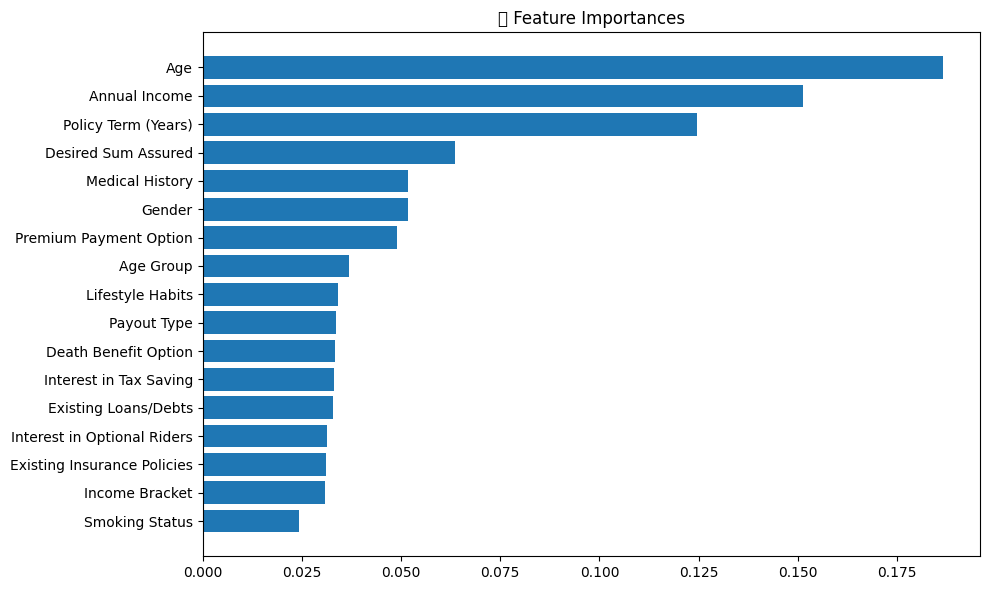

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ----------------------------- #
# STEP 1: Load & Clean Data     #
# ----------------------------- #

data = pd.read_csv("/content/drive/MyDrive/final_insurance_data.csv")

# Clean Income Criteria column
data['Income Criteria Cleaned'] = data['Income Criteria'].replace(
    {'\u20b9': '', 'L\+': '00000', 'L': '00000'}, regex=True)
data['Income Criteria Cleaned'] = pd.to_numeric(data['Income Criteria Cleaned'], errors='coerce').fillna(0).astype(int)

# Eligibility filters
data['Age Eligible'] = data.apply(lambda row: row['Entry Age Min'] <= row['Age'] <= row['Entry Age Max'], axis=1)
data['Sum Assured Eligible'] = data.apply(lambda row: row['Sum Assured Min'] <= row['Desired Sum Assured'] <= row['Sum Assured Max'], axis=1)
data['Income Eligible'] = data.apply(lambda row: row['Income Criteria Cleaned'] <= row['Annual Income'], axis=1)

data = data[data['Age Eligible'] & data['Sum Assured Eligible'] & data['Income Eligible']].copy()

# ----------------------------- #
# STEP 2: Feature Engineering   #
# ----------------------------- #

data['Age Group'] = pd.cut(data['Age'], bins=[0, 18, 30, 45, 60, 100], labels=['Child', 'Youth', 'Adult', 'MidAge', 'Senior'])
data['Income Bracket'] = pd.cut(data['Annual Income'], bins=[0, 300000, 700000, 1500000, 5000000, np.inf], labels=['Low', 'Lower-Mid', 'Mid', 'High', 'Very High'])

# ----------------------------- #
# STEP 3: Encode Features       #
# ----------------------------- #

features = [
    'Age', 'Gender', 'Smoking Status', 'Annual Income',
    'Existing Loans/Debts', 'Existing Insurance Policies',
    'Desired Sum Assured', 'Policy Term (Years)',
    'Premium Payment Option', 'Death Benefit Option',
    'Payout Type', 'Medical History', 'Lifestyle Habits',
    'Interest in Optional Riders', 'Interest in Tax Saving',
    'Age Group', 'Income Bracket'
]
target = 'Insurance Name'

label_encoders = {}
for col in features + [target]:
    if data[col].dtype == 'object' or str(data[col].dtype) == 'category':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# ----------------------------- #
# STEP 4: Custom Grouped Split  #
# ----------------------------- #

train_data = []
val_data = []
test_data = []

# Split per class
for label in data[target].unique():
    group = data[data[target] == label]
    total = len(group)

    train_count = int(0.5 * total)
    val_count = int(0.2 * total)

    shuffled = group.sample(frac=1, random_state=42)
    train_data.append(shuffled.iloc[:train_count])
    val_data.append(shuffled.iloc[train_count:train_count + val_count])
    test_data.append(shuffled.iloc[train_count + val_count:])

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
test_df = pd.concat(test_data)

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# ----------------------------- #
# STEP 5: Train Improved Model  #
# ----------------------------- #

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

# ----------------------------- #
# STEP 6: Evaluate Model        #
# ----------------------------- #

y_pred = model.predict(X_test)
print("\n\U0001F50D Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoders[target].classes_))

# ----------------------------- #
# STEP 7: Feature Importance    #
# ----------------------------- #

importances = model.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("\U0001F4CA Feature Importances")
plt.barh(range(len(importances)), importances[sorted_indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
# ----------------------------- #
# STEP 8: Test on One New User  #
# ----------------------------- #

# 👤 Test User Based on Training Row
test_sample = pd.DataFrame([{
    'Age': 56,
    'Gender': 'Female',
    'Smoking Status': 'Non-Smoker',
    'Annual Income': 1000000,
    'Existing Loans/Debts': 0,
    'Existing Insurance Policies': 1,
    'Desired Sum Assured': 8000,
    'Policy Term (Years)': 15,
    'Premium Payment Option': 'Limited',
    'Death Benefit Option': 'Increasing',
    'Payout Type': 'Installments',
    'Medical History': 'Diabetic',
    'Lifestyle Habits': 'Sedentary',
    'Interest in Optional Riders': False,
    'Interest in Tax Saving': True
}])

# Feature engineering (same bins as training)
test_sample['Age Group'] = pd.cut(
    test_sample['Age'],
    bins=[0, 18, 30, 45, 60, 100],
    labels=['Child', 'Youth', 'Adult', 'MidAge', 'Senior']
)
test_sample['Income Bracket'] = pd.cut(
    test_sample['Annual Income'],
    bins=[0, 300000, 700000, 1500000, 5000000, np.inf],
    labels=['Low', 'Lower-Mid', 'Mid', 'High', 'Very High']
)

# Safe encoding: handles unseen values by extending encoder
for col in features:
    if col in label_encoders:
        le = label_encoders[col]
        def safe_encode(val):
            if val in le.classes_:
                return le.transform([val])[0]
            else:
                le.classes_ = np.append(le.classes_, val)
                return le.transform([val])[0]
        test_sample[col] = test_sample[col].apply(safe_encode)

# Predict probabilities
X_new = test_sample[features].astype(float)
probs = model.predict_proba(X_new)[0]

# Get top 3 predicted insurance plans
top3_indices = np.argsort(probs)[::-1][:3]
top3_labels = label_encoders[target].inverse_transform(top3_indices)
top3_probs = probs[top3_indices]

# Output top 3 plans
print("\n🏆 Top 3 Recommended Insurance Plans for Test User:")
for i, (plan, prob) in enumerate(zip(top3_labels, top3_probs), start=1):
    print(f"{i}. {plan} (Confidence: {prob:.2%})")



🏆 Top 3 Recommended Insurance Plans for Test User:
1. LIC's Amritbaal (Confidence: 33.15%)
2. LIC's Bima Jyoti (Confidence: 8.36%)
3. LIC's New Children's Money Back Plan (Confidence: 8.04%)


In [21]:
import pandas as pd
import numpy as np

# 👤 Test User Based on Training Row
test_sample = pd.DataFrame([{
    'Age': 99,
    'Gender': 'Female',
    'Smoking Status': 'Non-Smoker',
    'Annual Income': 5433654,
    'Existing Loans/Debts': 1,
    'Existing Insurance Policies': 1,
    'Desired Sum Assured': 15000,
    'Policy Term (Years)': 32,
    'Premium Payment Option': 'Limited',
    'Death Benefit Option': 'Increasing',
    'Payout Type': 'Installments',
    'Medical History': 'Diabetic',
    'Lifestyle Habits': 'Sedentary',
    'Interest in Optional Riders': False,
    'Interest in Tax Saving': True
}])

# Feature engineering (same bins as training)
test_sample['Age Group'] = pd.cut(
    test_sample['Age'],
    bins=[0, 18, 30, 45, 60, 100],
    labels=['Child', 'Youth', 'Adult', 'MidAge', 'Senior']
)
test_sample['Income Bracket'] = pd.cut(
    test_sample['Annual Income'],
    bins=[0, 300000, 700000, 1500000, 5000000, np.inf],
    labels=['Low', 'Lower-Mid', 'Mid', 'High', 'Very High']
)

# Safe encoding: handles unseen values by extending encoder
for col in features:
    if col in label_encoders:
        le = label_encoders[col]
        def safe_encode(val):
            if val in le.classes_:
                return le.transform([val])[0]
            else:
                le.classes_ = np.append(le.classes_, val)
                return le.transform([val])[0]
        test_sample[col] = test_sample[col].apply(safe_encode)

# Predict probabilities
X_new = test_sample[features].astype(float)
probs = model.predict_proba(X_new)[0]

# Get top 3 predicted insurance plans
top3_indices = np.argsort(probs)[::-1][:3]
top3_labels = label_encoders[target].inverse_transform(top3_indices)
top3_probs = probs[top3_indices]

# Plan Suitability Scoring Function (Improved Heuristic)
def compute_suitability(plan, prob, user_row):
    score = prob * 100  # Base on confidence
    # Enhanced scoring based on different features
    if user_row['Interest in Tax Saving'] and 'Jeevan' in plan:
        score += 8
    if user_row['Desired Sum Assured'] < 50000 and 'Child' in plan:
        score += 7
    if user_row['Medical History'] == 'Diabetic' and 'Term' in plan:
        score += 5
    if user_row['Lifestyle Habits'] == 'Sedentary' and 'Critical Illness' in plan:
        score += 6
    if user_row['Income Bracket'] == 'Low' and 'Affordable' in plan:
        score += 4
    return round(score, 1)

# Comparison table
print("\n🏆 Top 3 Recommended Insurance Plans for Test User:\n")
comparison_data = []
for i, (plan, prob) in enumerate(zip(top3_labels, top3_probs), start=1):
    score = compute_suitability(plan, prob, test_sample.iloc[0])
    reason = []
    if 'Child' in plan and test_sample.iloc[0]['Age Group'] == 'Child':
        reason.append("Child-specific benefits")
    if 'Jeevan' in plan:
        reason.append("Strong traditional life cover")
    if 'Term' in plan:
        reason.append("Suitable for critical illnesses")
    if test_sample.iloc[0]['Interest in Tax Saving']:
        reason.append("High tax savings potential")
    if 'Critical Illness' in plan and test_sample.iloc[0]['Lifestyle Habits'] == 'Sedentary':
        reason.append("Better protection for sedentary lifestyle")
    if 'Affordable' in plan and test_sample.iloc[0]['Income Bracket'] == 'Low':
        reason.append("Affordable option for low-income bracket")
    comparison_data.append({
        'Rank': i,
        'Plan Name': plan,
        'Confidence': f"{prob:.2%}",
        'Suitability Score': score,
        'Reason for Recommendation': ', '.join(reason)
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))




🏆 Top 3 Recommended Insurance Plans for Test User:

 Rank                       Plan Name Confidence  Suitability Score  Reason for Recommendation
    1                 LIC's Amritbaal     27.48%               27.5 High tax savings potential
    2         Tata AIA Life Insurance     10.41%               10.4 High tax savings potential
    3 ICICI Prudential iProtect Smart     10.04%               10.0 High tax savings potential
